In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import spacy
import nltk

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Conv1D, MaxPooling1D, GRU, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
     

In [ ]:
# Download the pre-trained GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-04-13 05:52:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-13 05:52:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-13 05:52:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Base_path ='/content/drive/MyDrive/Data/hatexplain'

In [ ]:
df=pd.read_csv(Base_path+"/HateXplain2.csv")

In [ ]:
df.head()

,Unnamed: 0,post_id,rationales,post_tokens,Target_cat,Label_cat,final_rationales
0,0,1179055004553900032_twitter,[],"['i', 'dont', 'think', 'im', 'getting', 'my', ...",None,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1179063826874032128_twitter,[],"['we', 'cannot', 'continue', 'calling', 'ourse...",None,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,1178793830532956161_twitter,[],"['nawt', 'yall', 'niggers', 'ignoring', 'me']",African,normal,"[0, 0, 0, 0, 0]"
3,3,1179088797964763136_twitter,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",Asian,hatespeech,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,1179085312976445440_twitter,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","['this', 'bitch', 'in', 'whataburger', 'eating...",Women,hatespeech,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
data = df[['post_tokens',	'Target_cat',	'Label_cat',	'final_rationales']]
data['post_tokens'] = data['post_tokens'].apply(lambda x: eval(x))

<ipython-input-7-71b9c50e4ec9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_tokens'] = data['post_tokens'].apply(lambda x: eval(x))


In [ ]:
data['post_tokens']

0        [i, dont, think, im, getting, my, baby, them, ...
1        [we, cannot, continue, calling, ourselves, fem...
2                      [nawt, yall, niggers, ignoring, me]
3        [<user>, i, am, bit, confused, coz, chinese, p...
4        [this, bitch, in, whataburger, eating, a, burg...
                               ...                        
20143    [if, ur, still, on, twitter, tell, carlton, i,...
20144    [when, i, first, got, on, here, and, said, i, ...
20145    [was, macht, der, moslem, wenn, der, zion, geg...
20146    [it, is, awful, look, at, world, demographics,...
20147    [the, jewish, globalist, elite, have, only, im...
Name: post_tokens, Length: 20148, dtype: object

In [ ]:
for i in range(len(data)):
  sentence =""
  for j in (data['post_tokens'].iloc[i]):
    sentence += j +" "
  data['post_tokens'].iloc[i] = sentence

<ipython-input-9-751387b6647d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['post_tokens'].iloc[i] = sentence


In [ ]:
data.head()

,post_tokens,Target_cat,Label_cat,final_rationales
0,i dont think im getting my baby them white 9 h...,None,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,we cannot continue calling ourselves feminists...,None,normal,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,nawt yall niggers ignoring me,African,normal,"[0, 0, 0, 0, 0]"
3,<user> i am bit confused coz chinese ppl can n...,Asian,hatespeech,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,this bitch in whataburger eating a burger with...,Women,hatespeech,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
label_map = {'hatespeech': 0, 'normal': 1, 'offensive': 2}
labels = data["Label_cat"].apply(lambda x: label_map[x])

In [ ]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
20143    2
20144    2
20145    1
20146    0
20147    2
Name: Label_cat, Length: 20148, dtype: int64

In [ ]:
max_words = 30000
maxlen = 100

In [ ]:
# Tokenize the text data and convert it to sequences of integers
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['post_tokens'])
sequences = tokenizer.texts_to_sequences(df['post_tokens'])
X = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
# Define the target labels
y = pd.get_dummies(df['Label_cat']).values

In [ ]:
# Load the pre-trained GloVe embeddings
embedding_dict = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

In [ ]:
# Initialize the embedding matrix with pre-trained GloVe embeddings
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Define the input and output sizes
input_size = 1000
output_size = 10

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2885800   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 3,015,851
Trainable params: 3,015,851
Non-

In [ ]:
history=model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
504/504 [==============================] - 171s 321ms/step - loss: 0.8670 - accuracy: 0.5975 - val_loss: 0.9885 - val_accuracy: 0.5035
Epoch 2/10
504/504 [==============================] - 159s 316ms/step - loss: 0.6030 - accuracy: 0.7551 - val_loss: 1.0541 - val_accuracy: 0.5112
Epoch 3/10
504/504 [==============================] - 164s 326ms/step - loss: 0.3991 - accuracy: 0.8499 - val_loss: 1.3122 - val_accuracy: 0.4950
Epoch 4/10
504/504 [==============================] - 162s 322ms/step - loss: 0.2622 - accuracy: 0.9064 - val_loss: 1.6331 - val_accuracy: 0.4876
Epoch 5/10
504/504 [==============================] - 163s 323ms/step - loss: 0.1699 - accuracy: 0.9409 - val_loss: 1.9946 - val_accuracy: 0.4794
Epoch 6/10
504/504 [==============================] - 162s 322ms/step - loss: 0.1238 - accuracy: 0.9595 - val_loss: 2.2023 - val_accuracy: 0.4777
Epoch 7/10
504/504 [==============================] - 161s 319ms/step - loss: 0.1009 - accuracy: 0.9648 - val_loss: 2.4173 -

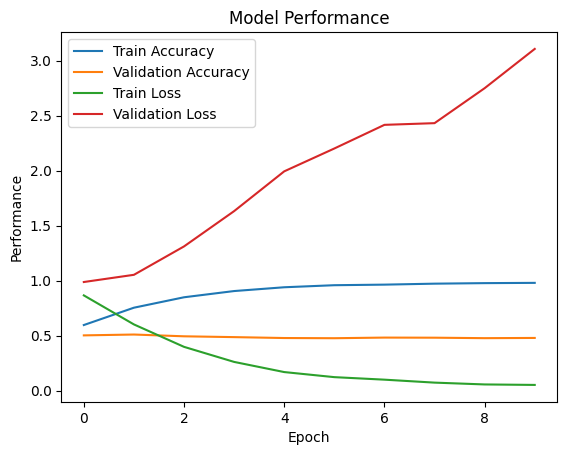

In [ ]:
# Plot the history of accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_pred = np.argmax(model.predict(X), axis=-1)

# Convert the labels from one-hot encoding to integers
y_test_int = np.argmax(y, axis=1)    

630/630 [==============================] - 67s 101ms/step


In [ ]:
print(classification_report(y_test_int, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5934
           1       0.90      0.93      0.92      7814
           2       0.88      0.81      0.84      6400

    accuracy                           0.89     20148
   macro avg       0.89      0.89      0.89     20148
weighted avg       0.89      0.89      0.89     20148



In [ ]:
model.save("/content/drive/MyDrive/Reproducibility/BiRNN.h5")

In [ ]:
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#print AUC score
print(auc)

0.5602104030579559